# CMSC320 - Introduction to Data Science
## Final Tutorial
#### David Martin
---

The purpose of this tutorial is to perform an analysis of COVID data across the state of Virginia.

In [211]:
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
import requests
import difflib
import re
from fuzzywuzzy import process
from bs4 import BeautifulSoup
plt.style.use('seaborn-whitegrid')

## Data Collection

Lets start by pulling the data from the dataset "VDH-COVID-19-PublicUseDataset-Cases" as found on data.virginia.gov, and taking a look at what it contains:

https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr

I uploaded the .csv to my GitHub at the following link:

https://github.com/martindavid1995/Data-Science-Tutorial

In [212]:
# Pull data on COVID cases across Virginia
covid_data = pd.read_csv("https://raw.githubusercontent.com/martindavid1995/Data-Science-Tutorial/master/Covid_VA.csv")
covid_data.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths
0,03/17/2020,51001,Accomack,Eastern Shore,0,0,0
1,03/17/2020,51003,Albemarle,Thomas Jefferson,0,0,0
2,03/17/2020,51005,Alleghany,Alleghany,0,0,0
3,03/17/2020,51007,Amelia,Piedmont,0,0,0
4,03/17/2020,51009,Amherst,Central Virginia,0,0,0


## Data Management

Now that we have our dataset imported, lets start looking at what we have to work with. In order to visualize our data, we should look to find what 

In [213]:
print("Total number of columns in the dataset: ",len(covid_data.index))

Total number of columns in the dataset:  103607


As we can see, we have a pretty large set of data. Over 100,000 rows with seemingly an entry for each locality for each date within the specified range. Lets see what the day range looks like:

In [214]:
# Prints the minimum and maximum values of a specified column in a DataFrame
def printMinMax(df, column):
    print("Min: ",df[column].min())
    print("Max: ",df[column].max())
    
printMinMax(covid_data, "Report Date")

Min:  01/01/2021
Max:  12/31/2021


If we look at the results of the above cell, we notice our first issue with this dataset. The date range from the days above shows January 1, 2021 as being the earliest recorded date when we can clearly see from the head output in the above cells that we have columns with dates going back into 2020. This must be because there is some inability to compare these date objects in the current dataframe accurately. Lets convert the dates into DateTime objects so we can figure out our actual date range, and manipulate and visualize our data better.

In [215]:
# Split each date string into its components
def dateToDateTime(date: str):
    split = date.split("/")
    month = int(split[0])
    day = int(split[1])
    year = int(split[2])
    # Return a new DateTime object 
    return datetime.date(year, month, day)
    
# Convert each row's Report Date into a readable DateTime
def convertDateTime(df):
    datetimes = []
    for index,row in df.iterrows():
        date = df.at[index, "Report Date"]
        datetimes.append(dateToDateTime(date))
    
    # Add the new DateTimes to the original DataFrame
    df['DateTime'] = datetimes
    return df

covid_data = convertDateTime(covid_data)
covid_data.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,DateTime
0,03/17/2020,51001,Accomack,Eastern Shore,0,0,0,2020-03-17
1,03/17/2020,51003,Albemarle,Thomas Jefferson,0,0,0,2020-03-17
2,03/17/2020,51005,Alleghany,Alleghany,0,0,0,2020-03-17
3,03/17/2020,51007,Amelia,Piedmont,0,0,0,2020-03-17
4,03/17/2020,51009,Amherst,Central Virginia,0,0,0,2020-03-17


With the new DateTime column added, lets check to see what our actual date range looks like for this dataset.

In [216]:
printMinMax(covid_data, "DateTime")

Min:  2020-03-17
Max:  2022-05-04


Now we have a column with dates that we can actually compare in our data analysis. We can see that our data's report dates span from March 2020 to May 2022. Lets see what counties we have, how many dates are recorded, and see if each county has a report for each date.

In [217]:
# Get a list of the unique counties
counties = covid_data["Locality"].unique()
# Display how many unique counties are in our dataset
print("There are ",len(counties)," unique counties")

# Figure out how many unique dates we have data for
dates = covid_data["DateTime"].unique()
# Display how many unique dates we have
print("There are ",len(dates)," unique dates")

# Get the number of rows containing each unique date in our dataset
date_counts = covid_data["Report Date"].value_counts()
unique_dates = date_counts.unique()
# Display the unique date count values
print("Each date has ",unique_dates[0]," unique entries")

There are  133  unique counties
There are  779  unique dates
Each date has  133  unique entries


This above cell gives us a lot of great information. We now know that we have 133 Virginia counties whose COVID reporting data is in this dataset. We also know that each of the 133 counties has reported COVID data for each of the 779 dates recorded in this table. With this information, we can now move onto visualizing our data.

## Exploratory Data Analysis

Now that we know a bit more about our dataset and have made some slight modifications to make it more manipulatable, lets try to visualize our COVID data.

We can start by taking a look at cases over time:

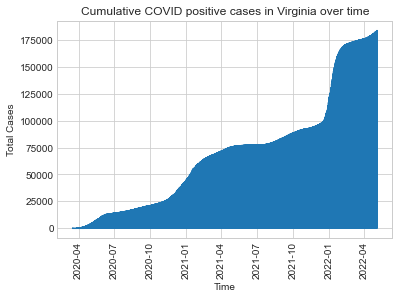

In [218]:
# Create figure and axes
fig = plt.figure()
ax = plt.axes()

# Plot with x axis as time and y axis as total cases
ax.plot(covid_data["DateTime"], covid_data["Total Cases"])

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Total Cases")
plt.title("Cumulative COVID positive cases in Virginia over time")

# Rotate ticks
plt.xticks(rotation=90)
plt.show()

As expected, the total number COVID cases in Virginia goes up over time. This is pretty intuitive as there is no way for the total cases to go down because it is a cumulative measure. From this chart we can gather some information about COVID contraction rates. We see two sections with steep slopes - January 2020 and January 2021 show massive relative spikes in new cases state-wide. This comes as no surprise, as the winter months involved cold/flu season as well as lots of family gatherings which might have added to the rate of spread. 

Instead of looking only at the cumulative cases, I think it would be interesting to see how many new cases, hospitalizations, and deaths are reported over time. We will also want to assess how these values flucuate from county to county, so we will separate the data by county. Lets do some more manipulation to our data in order visualize these changes.

In [219]:
# Takes a dataframe for a specific county and adds a column that shows the number of new cases reported for each report date
def genColumnDifference(df, column):
    offsets = []
    # For each row in the dataframe
    for index, row in df.iterrows():
        if index == 0:
            offsets.append(0)
        else:
            # Compute the difference in the specified column of the current report date minus the previous report date
            offsets.append(df.at[index, column] - df.at[index-1, column])
    # Append this column to the dataframe
    df[column+" Per Day"] = offsets
    return df

county_frames = []
# For each county 
for county in counties:
    # Construct a new dataframe consisting only of rows corresponding to this county
    county_frame = covid_data.loc[covid_data["Locality"] == county]
    # Reset the indices
    county_frame = county_frame.reset_index(drop=True)
    # Get the column differences for Total Cases, Hospitalizations, and Deaths
    county_frame = genColumnDifference(county_frame, "Total Cases")
    county_frame = genColumnDifference(county_frame, "Hospitalizations")
    county_frame = genColumnDifference(county_frame, "Deaths")
    # Add it to our list of counties
    county_frames.append(county_frame)

Now we have a separate DataFrame for each county, and each of those frames now has columns representing the daily cases, hospitalizations, and deaths. It might be useful in our analysis to obtain the case, death, and hospitalization rates for each of our counties. To get accurate representations of these rates, we're going to need to know each counties population. A google search of [Virginia Counties by Population](https://www.virginia-demographics.com/counties_by_population) brings us a chart with a value for each of Virginia's 133 counties. While we could sit here and manually enter the populations by hand, we can use python and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to strip the data out of this chart so that we don't have to. 

In [220]:
# Use requests to pull data from URL
r = requests.get("https://www.virginia-demographics.com/counties_by_population")
# Use BeautifulSoup to parse the request's HTML
soup = BeautifulSoup(r.content, 'html.parser')
# Find the table object and prettify it
table = soup.find('table').prettify()
# Convert the table into a DataFrame
populations = pd.read_html(str(table))[0]
# Drop the last row because it has data we don't need
populations = populations.drop(index=len(populations.index)-1)
populations.head()

,Rank,County,Population
0,1,Fairfax County,1149439
1,2,Prince William County,466834
2,3,Virginia Beach city/county,450882
3,4,Loudoun County,405312
4,5,Chesterfield County,348500


Great - We now have a DataFrame containing all of the 133 Virginia counties. We do have an issue in the way the county names are written between this DataFrame and our master DataFrame in our database. This will make it difficult for us to look up the population of a county using this table. We need to attempt to have a unique matching county name for each pair in each of our DataFrames so that we can easily access each counties population. We can use the Python library [FuzzyWuzzy](https://pypi.org/project/fuzzywuzzy/) to match our county names in one frame to line them up with one another. 

In [221]:
# Get all of the counties from populations DataFrame in a list
pop_counties = populations['County'].unique()

covid_data.at[(covid_data.index[covid_data['Locality'] == 'Charlotte County']),'Locality'] = 'Charlotte'
counties = covid_data["Locality"].unique()

# For each unique county name in our covid_data main DataFrame
for county in counties:
    # Use FuzzyWuzzy to find the value in the 'County' column of populations most similar to the value in the 'Locality' column in covid_data
    proc = process.extract(county, pop_counties, limit=1)
    # The match variable represents the matching county name in populations
    (match, score) = proc[0]
    # Get the index of that value in our populations frame
    index = populations.index[populations['County'] == match]
    # Rename the value in our populations frame so that it is identical to its respective county in in covid_data
    populations.at[index,'County'] = county
    
# populations.head()
print(populations.to_string())



    Rank            County Population
0      1           Fairfax    1149439
1      2    Prince William     466834
2      3    Virginia Beach     450882
3      4           Loudoun     405312
4      5      Chesterfield     348500
5      6           Henrico     330076
6      7           Norfolk     244300
7      8        Chesapeake     242647
8      9         Arlington     236434
9     10     Richmond City     229233
10    11      Newport News     179582
11    12        Alexandria     158309
12    13          Stafford     150185
13    14           Hampton     135169
14    15      Spotsylvania     134683
15    16         Albemarle     108819
16    17           Hanover     106538
17    18      Roanoke City      99122
18    19        Montgomery      98495
19    20        Portsmouth      94961
20    21    Roanoke County      94103
21    22           Suffolk      91383
22    23         Frederick      88054
23    24        Rockingham      81138
24    25         Lynchburg      80970
25    26    

Now that the county names match in both our data and population dataframes, we can define a function to pull population information out of our populations DataFrame for counties we are looking at in our county_frames which hold all of our covid data.

In [222]:
def getPopulation(county: str):
    return populations.loc[populations['County'] == county]['Population'].values[0]

In [223]:
vals = []
for county in counties:
    print("Searching for ",county)
    getPopulation(county)

    

Searching for  Accomack
Searching for  Albemarle
Searching for  Alleghany
Searching for  Amelia
Searching for  Amherst
Searching for  Appomattox
Searching for  Arlington
Searching for  Augusta
Searching for  Bath
Searching for  Bedford
Searching for  Bland
Searching for  Botetourt
Searching for  Brunswick
Searching for  Buchanan
Searching for  Buckingham
Searching for  Campbell
Searching for  Caroline
Searching for  Carroll
Searching for  Charles City
Searching for  Charlotte
Searching for  Chesterfield
Searching for  Clarke
Searching for  Craig
Searching for  Culpeper
Searching for  Cumberland
Searching for  Dickenson
Searching for  Dinwiddie
Searching for  Essex
Searching for  Fairfax
Searching for  Fauquier
Searching for  Floyd
Searching for  Fluvanna
Searching for  Franklin County
Searching for  Frederick
Searching for  Giles
Searching for  Gloucester
Searching for  Goochland
Searching for  Grayson
Searching for  Greene
Searching for  Greensville
Searching for  Halifax
Searching fo

IndexError: index 0 is out of bounds for axis 0 with size 0